# Final Project - The Battle of Neighborhoods 

In [1]:
import numpy as np # numpy
import time
import pandas as pd # pandas

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

!conda install -c conda-forge folium=0.5.0 --yes 
import folium
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

from sklearn.cluster import KMeans

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.


C:\Users\BojanVB>set "JAVA_HOME="  

C:\Users\BojanVB>set "JAVA_HOME_CONDA_BACKUP="  

C:\Users\BojanVB>set "JAVA_HOME=C:\Users\BojanVB\Anaconda3\Library"  
Solving environment: ...working... done

# All requested packages already installed.


C:\Users\BojanVB>set "JAVA_HOME="  

C:\Users\BojanVB>set "JAVA_HOME_CONDA_BACKUP="  

C:\Users\BojanVB>set "JAVA_HOME=C:\Users\BojanVB\Anaconda3\Library"  
Libraries imported.


# Introduction

In this project I will be looking at how similar or dissimilar are Downtown Singapore and Manhattan, with the goal to find a rental apartment in Manhattan which meets different demands

# Data Description

In order to make a good choice for an apartment in Manhattan, the following data is required: 
-	List of neighbourhoods in Manhattan with their Geodata (latitude and longitude)
-	List of the subway metro stations in Manhattan with geodata 
-	List of apartments for rent in Manhattan with descriptions (number of beds, price, location, address) 
-	Venues and amenities in the neighbourhoods

Once I have the data, I can use Foursquare and geopy data to map the top 10 venues for all Manhattan neighbourhoods and cluster them in groups. I can map the location of subway metro stations in order to be able to identify the venues and amenities near each metro station. I can also map the location of rental places linked to the subway locations. I could create a map that depicts, for example, the average rental price per square ft, within a radius of 1.0 mile around each subway station. I will be able to quickly point to the popups to know the relative price per subway area. Addresses from rental locations will be converted to geodata( lat, long) using Geopy-distance and Nominatim.

# Methodology

The methodology is based on the mapping of the data in section 2 in different ways, thus allowing throughout the use of a visual approach, i.e. by means of maps with popups labels, a quick identification of apartments according to the demands.

Let's first map the venues of the neigbourhood in Singapore

In [4]:
address = 'Mccallum Street, Singapore'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

C:\Users\BojanVB\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [5]:
neighborhood_latitude=1.2792655
neighborhood_longitude=103.8480938

CLIENT_ID = 'LH2SJ5V5CIGQST3SA44UI1NQH0EQF5CEA4MIQMM3A123I5OB' # your Foursquare ID
CLIENT_SECRET = 'GT5FHWGAJYML4HDDL1STGOJ4P0RBOWXQ5JFZEGES1RUF3BJN' # your Foursquare Secret
VERSION = '20200321' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
venues = results['response']['groups'][0]['items']
SGnearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
SGnearby_venues =SGnearby_venues.loc[:, filtered_columns]
# filter the category for each row
SGnearby_venues['venue.categories'] = SGnearby_venues.apply(get_category_type, axis=1)
# clean columns
SGnearby_venues.columns = [col.split(".")[-1] for col in SGnearby_venues.columns]

SGnearby_venues.shape
SGnearby_venues.head(10)

,name,categories,lat,lng
0,Napoleon Food & Wine Bar,Wine Bar,1.279925,103.847333
1,Pepper Bowl,Asian Restaurant,1.279371,103.846710
2,Native,Cocktail Bar,1.280135,103.846844
3,Park Bench Deli,Deli / Bodega,1.279872,103.847287
4,Mellower Coffee,Café,1.277814,103.848188
5,Muchachos,Burrito Place,1.279072,103.847026
6,Dumpling Darlings,Dumpling Restaurant,1.280483,103.846942
7,Sofitel So Singapore,Hotel,1.280017,103.849813
8,PS.Cafe,Café,1.280468,103.846264
9,ShuKuu Izakaya,Japanese Restaurant,1.280111,103.847762


In [8]:
latitude=1.2792655
longitude=103.8480938
# create map of Singapore place  using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=18)
# add markers to map
for lat, lng, label in zip(SGnearby_venues['lat'], SGnearby_venues['lng'], SGnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=7,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(map_sg)  
    
map_sg

Now we can do the same for Manhattan

In [9]:
manhattan_data  = pd.read_csv('mh_neigh_data.csv') 
manhattan_merged = pd.read_csv('manhattan_merged.csv')
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Mobile Phone Shop,Pizza Place,Sandwich Place,Park,Gym,Latin American Restaurant,Tapas Restaurant,Mexican Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Mexican Restaurant,Coffee Shop,Café,Deli / Bodega,Pizza Place,Liquor Store,Indian Restaurant,Sushi Restaurant,Sandwich Place,Yoga Studio


In [10]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558 

kclusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
  # add markers for rental places to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)    
    
       
map_clusters

Below a deeper exploration of cluster 2

In [11]:
## kk is the cluster number to explore
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Chinatown,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center
9,Yorkville,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub
14,Clinton,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater
23,Soho,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Café,Deli / Bodega,Tennis Court
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant
39,Hudson Yards,Coffee Shop,Italian Restaurant,Hotel,Theater,American Restaurant,Café,Gym / Fitness Center,Thai Restaurant,Restaurant,Gym


Now we can map the palces for rent in Manhattan and analyse the prices

In [12]:
mh_rent=pd.read_csv('MH_flats_price.csv')
mh_rent=pd.read_csv('MH_rent_latlong.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299


We can anlyse the rent price in Manhattan

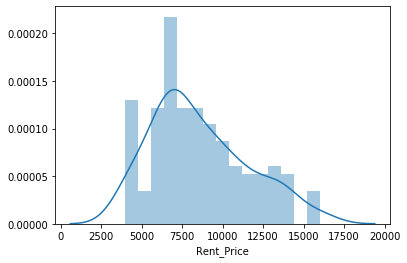

In [13]:
import seaborn as sns
sns.distplot(mh_rent['Rent_Price'],bins=15)

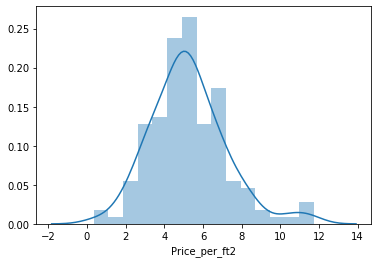

In [14]:
import seaborn as sns
sns.distplot(mh_rent['Price_per_ft2'],bins=15)

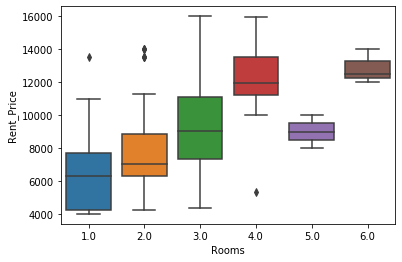

In [15]:
sns.boxplot(x='Rooms', y= 'Rent_Price', data=mh_rent)

In [16]:
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ',  '+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    

map_manhattan_rent

Now we can map the subway locations

In [17]:
mh=pd.read_csv('NYC_subway_list.csv')
sLength = len(mh['sub_station'])
lat = pd.Series(np.random.randn(sLength))
long=pd.Series(np.random.randn(sLength))
mh = mh.assign(lat=lat.values)
mh = mh.assign(long=long.values)

In [18]:
mh=pd.read_csv('MH_subway.csv')
print(mh.shape)
mh.head()

(76, 4)


,sub_station,sub_address,lat,long
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA",40.861857,-73.924509
1,57 Street Subway Station,"New York, NY 10106, USA",40.764250,-73.954525
2,Broad St,"New York, NY 10005, USA",40.730862,-73.987156
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA",40.847991,-73.939785
4,5 Av and 53 St,"New York, NY 10022, USA",40.764250,-73.954525


We have everything we need to map rental places, subway locations and cluster of venues
This allows me to have a quick overview on appartments which meet my demands (price, venues, subways...)

In [21]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

mhsub1=mh.drop_duplicates(subset=['lat','long'], keep="last").reset_index(drop=True)

map_mhsub1 = folium.Map(location=[latitude, longitude], zoom_start=12)
map_mh_one = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ', '+mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mh_one) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_mh_one)

    # set color scheme for the clusters
kclusters=5
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_mh_one)

    # Adds tool to the top right
from folium.plugins import MeasureControl
map_mh_one.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_mh_one)

map_mh_one

In [22]:
## kk is the cluster number to explore
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Chinatown,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center
9,Yorkville,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub
14,Clinton,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater
23,Soho,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Café,Deli / Bodega,Tennis Court
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant
39,Hudson Yards,Coffee Shop,Italian Restaurant,Hotel,Theater,American Restaurant,Café,Gym / Fitness Center,Thai Restaurant,Restaurant,Gym


# Results and Conclusions

From the map showed above I was able to quickly select the apartments best fitted my needs. 
Apartment on 305 East 63rd Street in the Sutton Place Neighbourhood and near 'subway 59th Street' station, Cluster # 2 Monthly rent : 7500 Dollars
The methodology use allows for a quick and easy selection of apartments while using an interactive map.
Also, it allowed me to compare the similarity of neighbourhoods in different cities. 